In [13]:
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from dataclasses import dataclass
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import yfinance as yf
from IPython.display import display, clear_output

[*********************100%%**********************]  2 of 2 completed


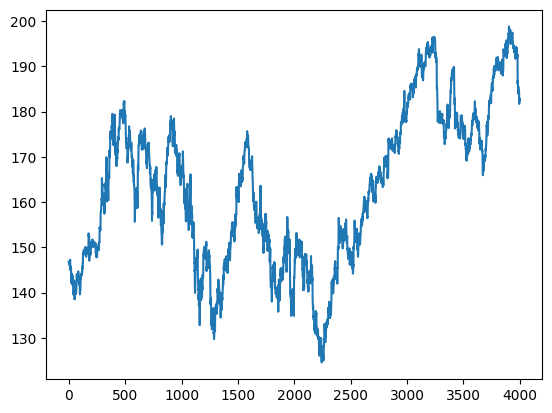

In [14]:
data = yf.download("SPY AAPL", period="600d", interval="1h")
y = data["Adj Close"]["AAPL"].values
y = y[:4000]
plt.plot(y)

In [15]:
class Model(nn.Module):

    # FITS: Frequency Interpolation Time Series Forecasting

    def __init__(self, configs):
        super(Model, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.individual = configs.individual
        self.channels = configs.enc_in

        self.dominance_freq=configs.cut_freq # 720/24
        self.length_ratio = (self.seq_len + self.pred_len)/self.seq_len

        if self.individual:
            self.freq_upsampler = nn.ModuleList()
            for i in range(self.channels):
                self.freq_upsampler.append(nn.Linear(self.dominance_freq, int(self.dominance_freq*self.length_ratio)).to(torch.cfloat))

        else:
            self.freq_upsampler = nn.Linear(self.dominance_freq, int(self.dominance_freq*self.length_ratio)).to(torch.cfloat)


    def forward(self, x):
        # RIN
        x_mean = torch.mean(x, dim=1, keepdim=True)
        x = x - x_mean
        x_var=torch.var(x, dim=1, keepdim=True)+ 1e-5
        x = x / torch.sqrt(x_var)

        low_specx = torch.fft.rfft(x, dim=1)
        low_specx[:,self.dominance_freq:]=0 # LPF
        low_specx = low_specx[:,0:self.dominance_freq,:] # LPF
        if self.individual:
            low_specxy_ = torch.zeros([low_specx.size(0),int(self.dominance_freq*self.length_ratio),low_specx.size(2)],dtype=low_specx.dtype).to(low_specx.device)
            for i in range(self.channels):
                low_specxy_[:,:,i]=self.freq_upsampler[i](low_specx[:,:,i].permute(0,1)).permute(0,1)
        else:
            low_specxy_ = self.freq_upsampler(low_specx.permute(0,2,1)).permute(0,2,1)
        low_specxy = torch.zeros([low_specxy_.size(0),int((self.seq_len+self.pred_len)/2+1),low_specxy_.size(2)],dtype=low_specxy_.dtype).to(low_specxy_.device)
        low_specxy[:,0:low_specxy_.size(1),:]=low_specxy_ 
        low_xy=torch.fft.irfft(low_specxy, dim=1)
        low_xy=low_xy * self.length_ratio 
        xy=(low_xy) * torch.sqrt(x_var) +x_mean
        return xy, low_xy* torch.sqrt(x_var)



In [18]:
@dataclass
class Config:
    seq_len: int = 200
    pred_len: int = 50
    individual: bool = False
    enc_in: int = 1
    cut_freq: int = 50

config = Config()

model=Model(config)
for param in model.parameters():
    param.data.fill_(0)

model_optim=optim.Adam(model.parameters(),lr=1e-4)
criterion=nn.MSELoss()

'Final Epoch: 999 Loss: 8.4913458442688'

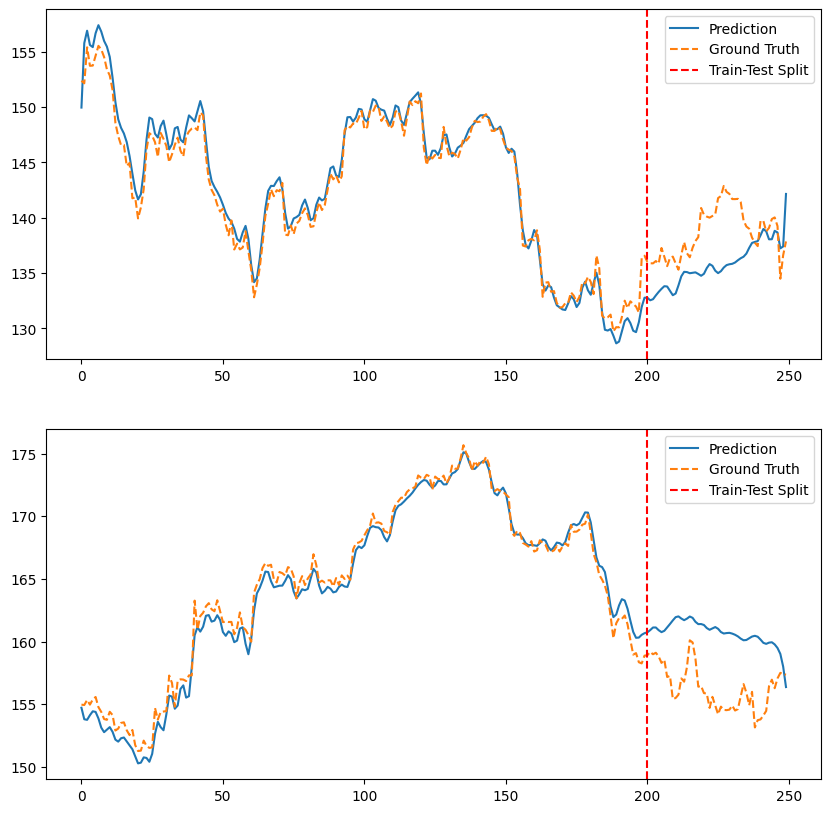

In [19]:
def train(model: nn.Module, config: dataclass, epochs: int = 1000):

    for epoch in tqdm(range(epochs), desc='Training Progress'):
        order = np.random.permutation(2000)
        train_loss = []
        for batch in range(25):
            batch_start = order[batch*80:(batch+1)*80]
            batch = []
            for i in batch_start:
                batch.append(y[i:i+config.seq_len+config.pred_len])
            batch_xy = np.array(batch).reshape(80, config.seq_len+config.pred_len, 1)
            batch_xy = torch.from_numpy(batch_xy).float()

            batch_x = batch_xy[:, :config.seq_len, :]
            batch_y = batch_xy[:, config.seq_len:, :]

            model_optim.zero_grad()

            output, _ = model(batch_x)

            loss = criterion(output, batch_xy)

            train_loss.append(loss.item())

            loss.backward()

            model_optim.step()

        clear_output(wait=True)
        display(f'Epoch: {epoch} Loss: {np.mean(train_loss)}')

    clear_output(wait=True)
    display(f'Final Epoch: {epoch} Loss: {np.mean(train_loss)}')

    output=output.cpu().detach().numpy()
    batch_xy=batch_xy.cpu().detach().numpy()
    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.plot(output[0,:,0], label="Prediction")
    plt.plot(batch_xy[0,:,0],'--', label="Ground Truth")
    plt.axvline(config.seq_len, color='r', linestyle='--', label="Train-Test Split")
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(output[1,:,0], label="Prediction")
    plt.plot(batch_xy[1,:,0], '--', label="Ground Truth")
    plt.axvline(config.seq_len, color='r', linestyle='--', label="Train-Test Split")
    plt.legend()
    plt.show()

train(model, Config())